In [1]:
from functions import *

RDKit WARNING: [14:23:19] Enabling RDKit 2019.09.3 jupyter extensions
[14:23:19] Enabling RDKit 2019.09.3 jupyter extensions
/home/martina/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# SYSTEM PARAMETERS

In [2]:
XYZ_DIR = './DPPC_DIPC/'
OUT_DIR = './out_data/'

XYZ_TRAJ = XYZ_DIR + 'PO4.xyz'
XYZ_BOX = XYZ_DIR + 'PO4.box'

# nparticles
N=1150
# trj part
INIT=0
END=1001
STRIDE=1


In [3]:
# mda universe from xyz and box
# if box changes over time: xl yl zl column file (assuming angles [90,90,90])
# if box is constant [[xv1,xv2,xv3],[yv1,yv2,yv3],[zv1,zv2,zv3]]
XYZ_UNI = xyz_to_uni(XYZ_TRAJ, XYZ_BOX)

## Compute RDF to find cut off radius

In [4]:
# rdf parms
interval=50
bins=200
# rdf
rdf_, rdf_array = get_gofr_all(XYZ_UNI, INIT, END, STRIDE, rcut=interval, bins=bins)

/home/martina/anaconda3/lib/python3.8/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
/home/martina/anaconda3/lib/python3.8/site-packages/MDAnalysis/analysis/rdf.py:324: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)


In [5]:
rcut=16
maximum = np.max(np.transpose(rdf_array)[1][argrelextrema(np.transpose(rdf_array)[1], np.greater)[0]])

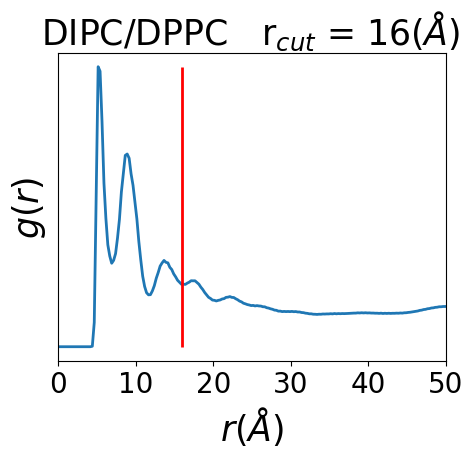

In [7]:
fig, ax = plt.subplots(1, figsize=(5,4), dpi=100)
_=ax.plot(rdf_.bins, rdf_.rdf,linewidth=2)
_=ax.set_title("DIPC/DPPC   r$_{cut}$ "f"= ${np.round(rcut,1)} (\AA)$ ", size=25)
_=ax.set_xlabel(r"$r (\AA)$", size=25)
_=ax.set_ylabel(r"$g(r)$", size=25)
_=ax.set_xlim([0,50])
_=ax.vlines(rcut, 0, maximum, colors='red',linewidth=2)
_=plt.xticks(fontsize=20)
ax.set_yticks([])
plt.savefig(OUT_DIR+'rdf.svg')

# STATISTICAL ANALISYS

## Contacts

In [8]:
# computre D_i^T lists
X_all = perform_search(XYZ_UNI, rcut, INIT, END, STRIDE, False)
np.shape(X_all)

/home/martina/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(1150, 1150, 2)

In [9]:
# contruct the D^T matrix (N,N)
M = np.array([[X_all[i][j][1] for i in range(N)] for j in range(N)])
x = np.arange(0,N)

## Distributions

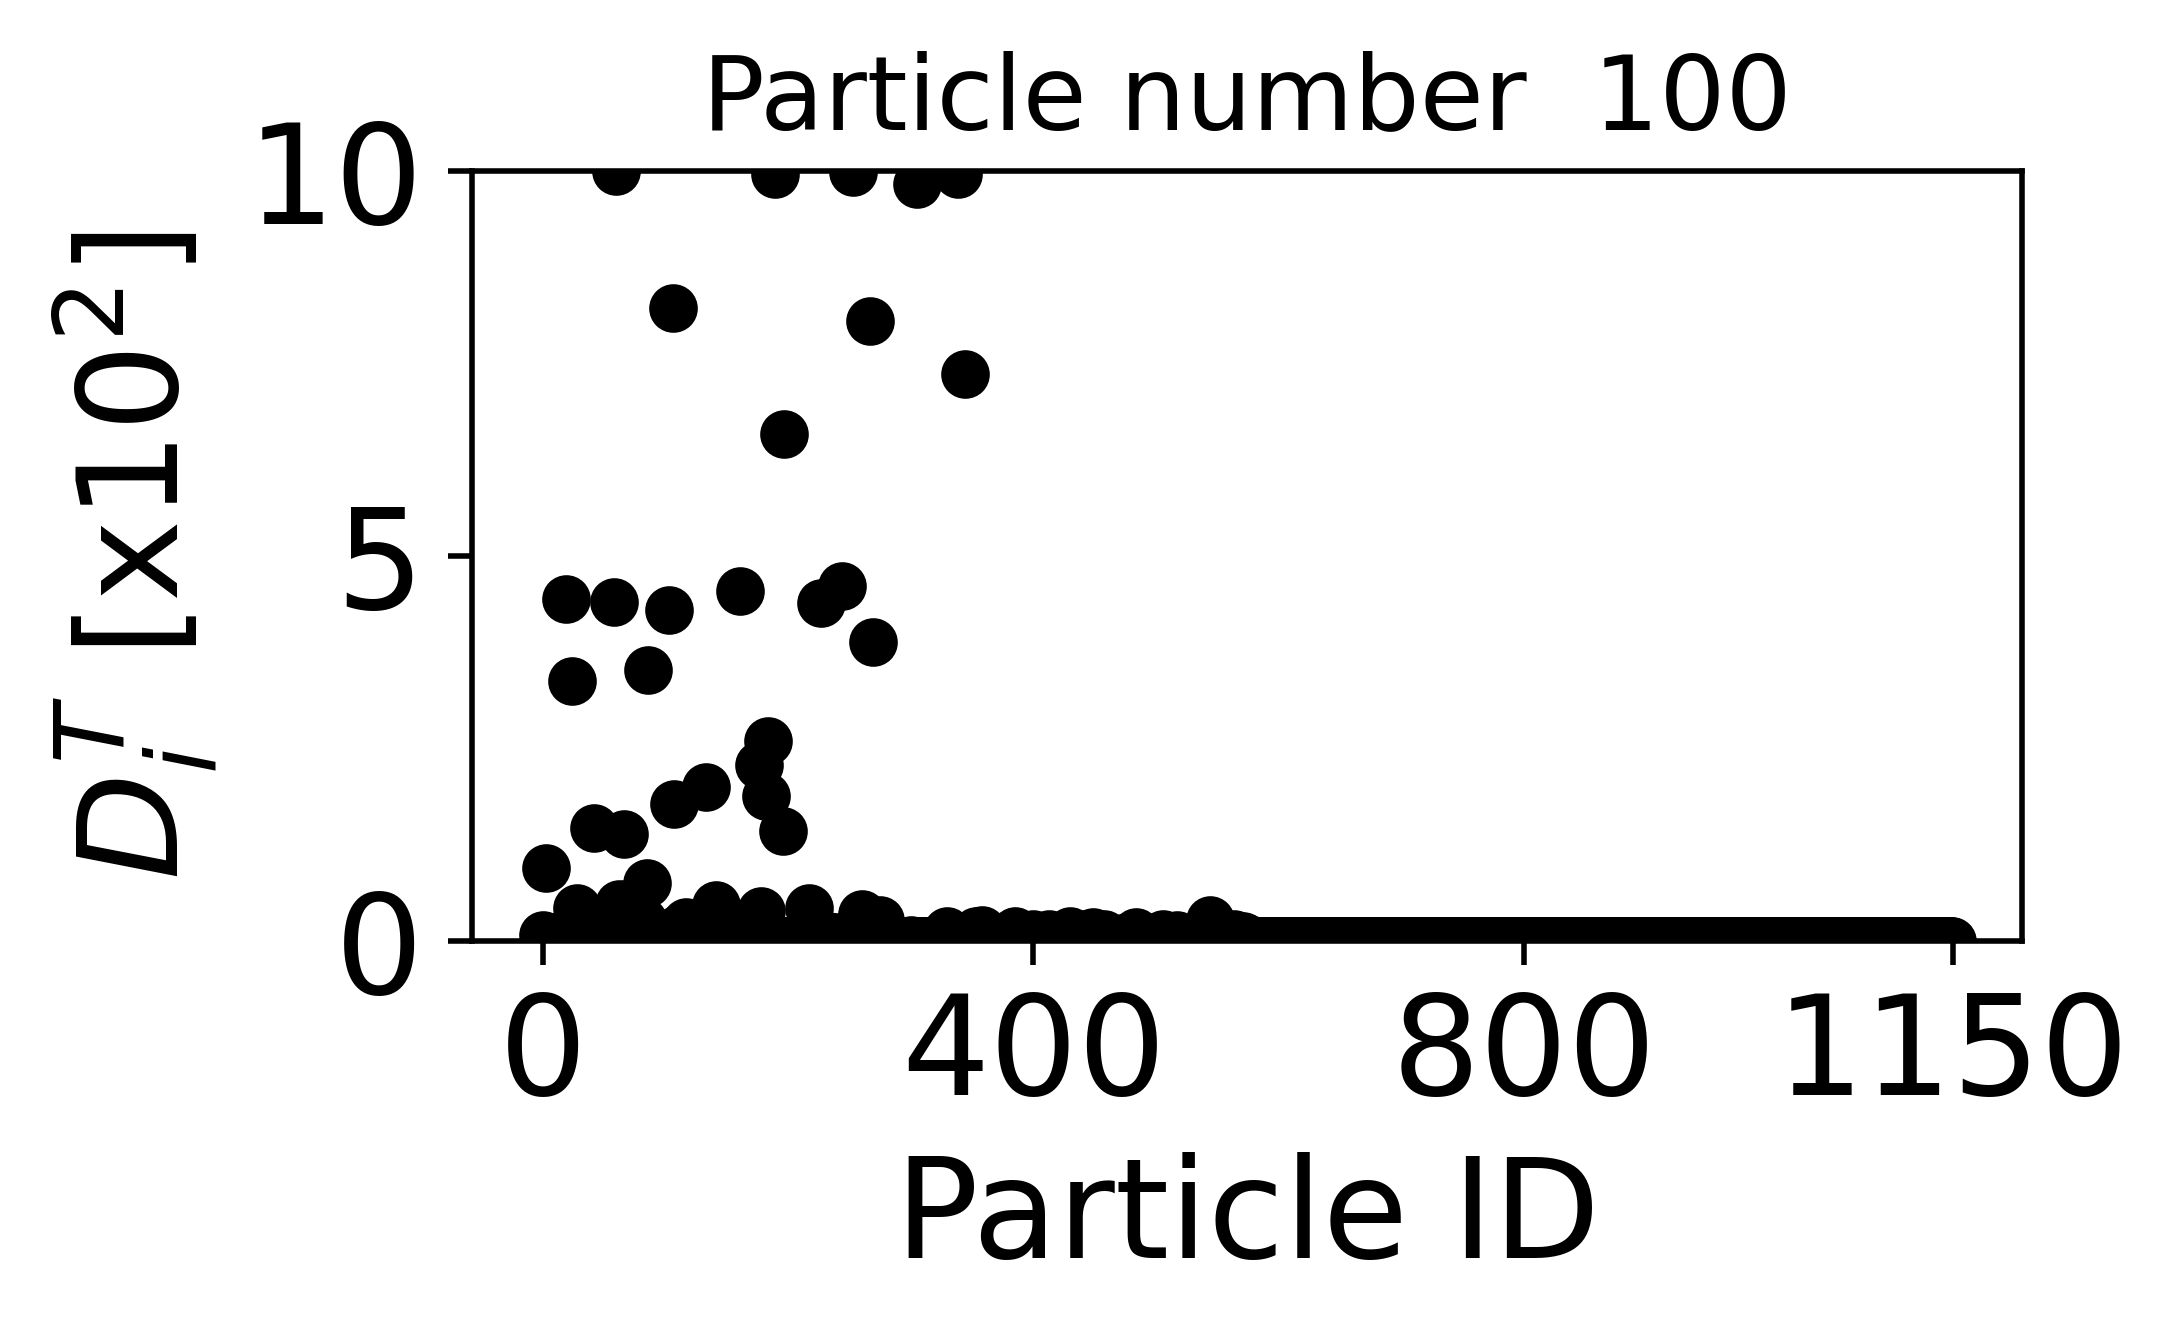

In [10]:
# Example D_i^T for i=100
fig, ax = plt.subplots(figsize=(4,2), dpi=500)
i = 100
y = M[i]
ax.scatter(x,y, marker='o', c='black')
ax.set_ylabel('$D_i^T$ [x$10^2$]', size=20)
ax.set_xticks([0,400,800,1150])
ax.set_xticklabels([0,400,800,1150],size=20)
ax.set_yticks([0,500,1000])
ax.set_yticklabels([0,5,10], size=20)
ax.set_xlabel('Particle ID', size=20)
plt.title('Particle number  '+str(i), size=15)
ax.set_ylim([0, np.max(M)])
plt.savefig(OUT_DIR+'cont.svg')

## Clustering

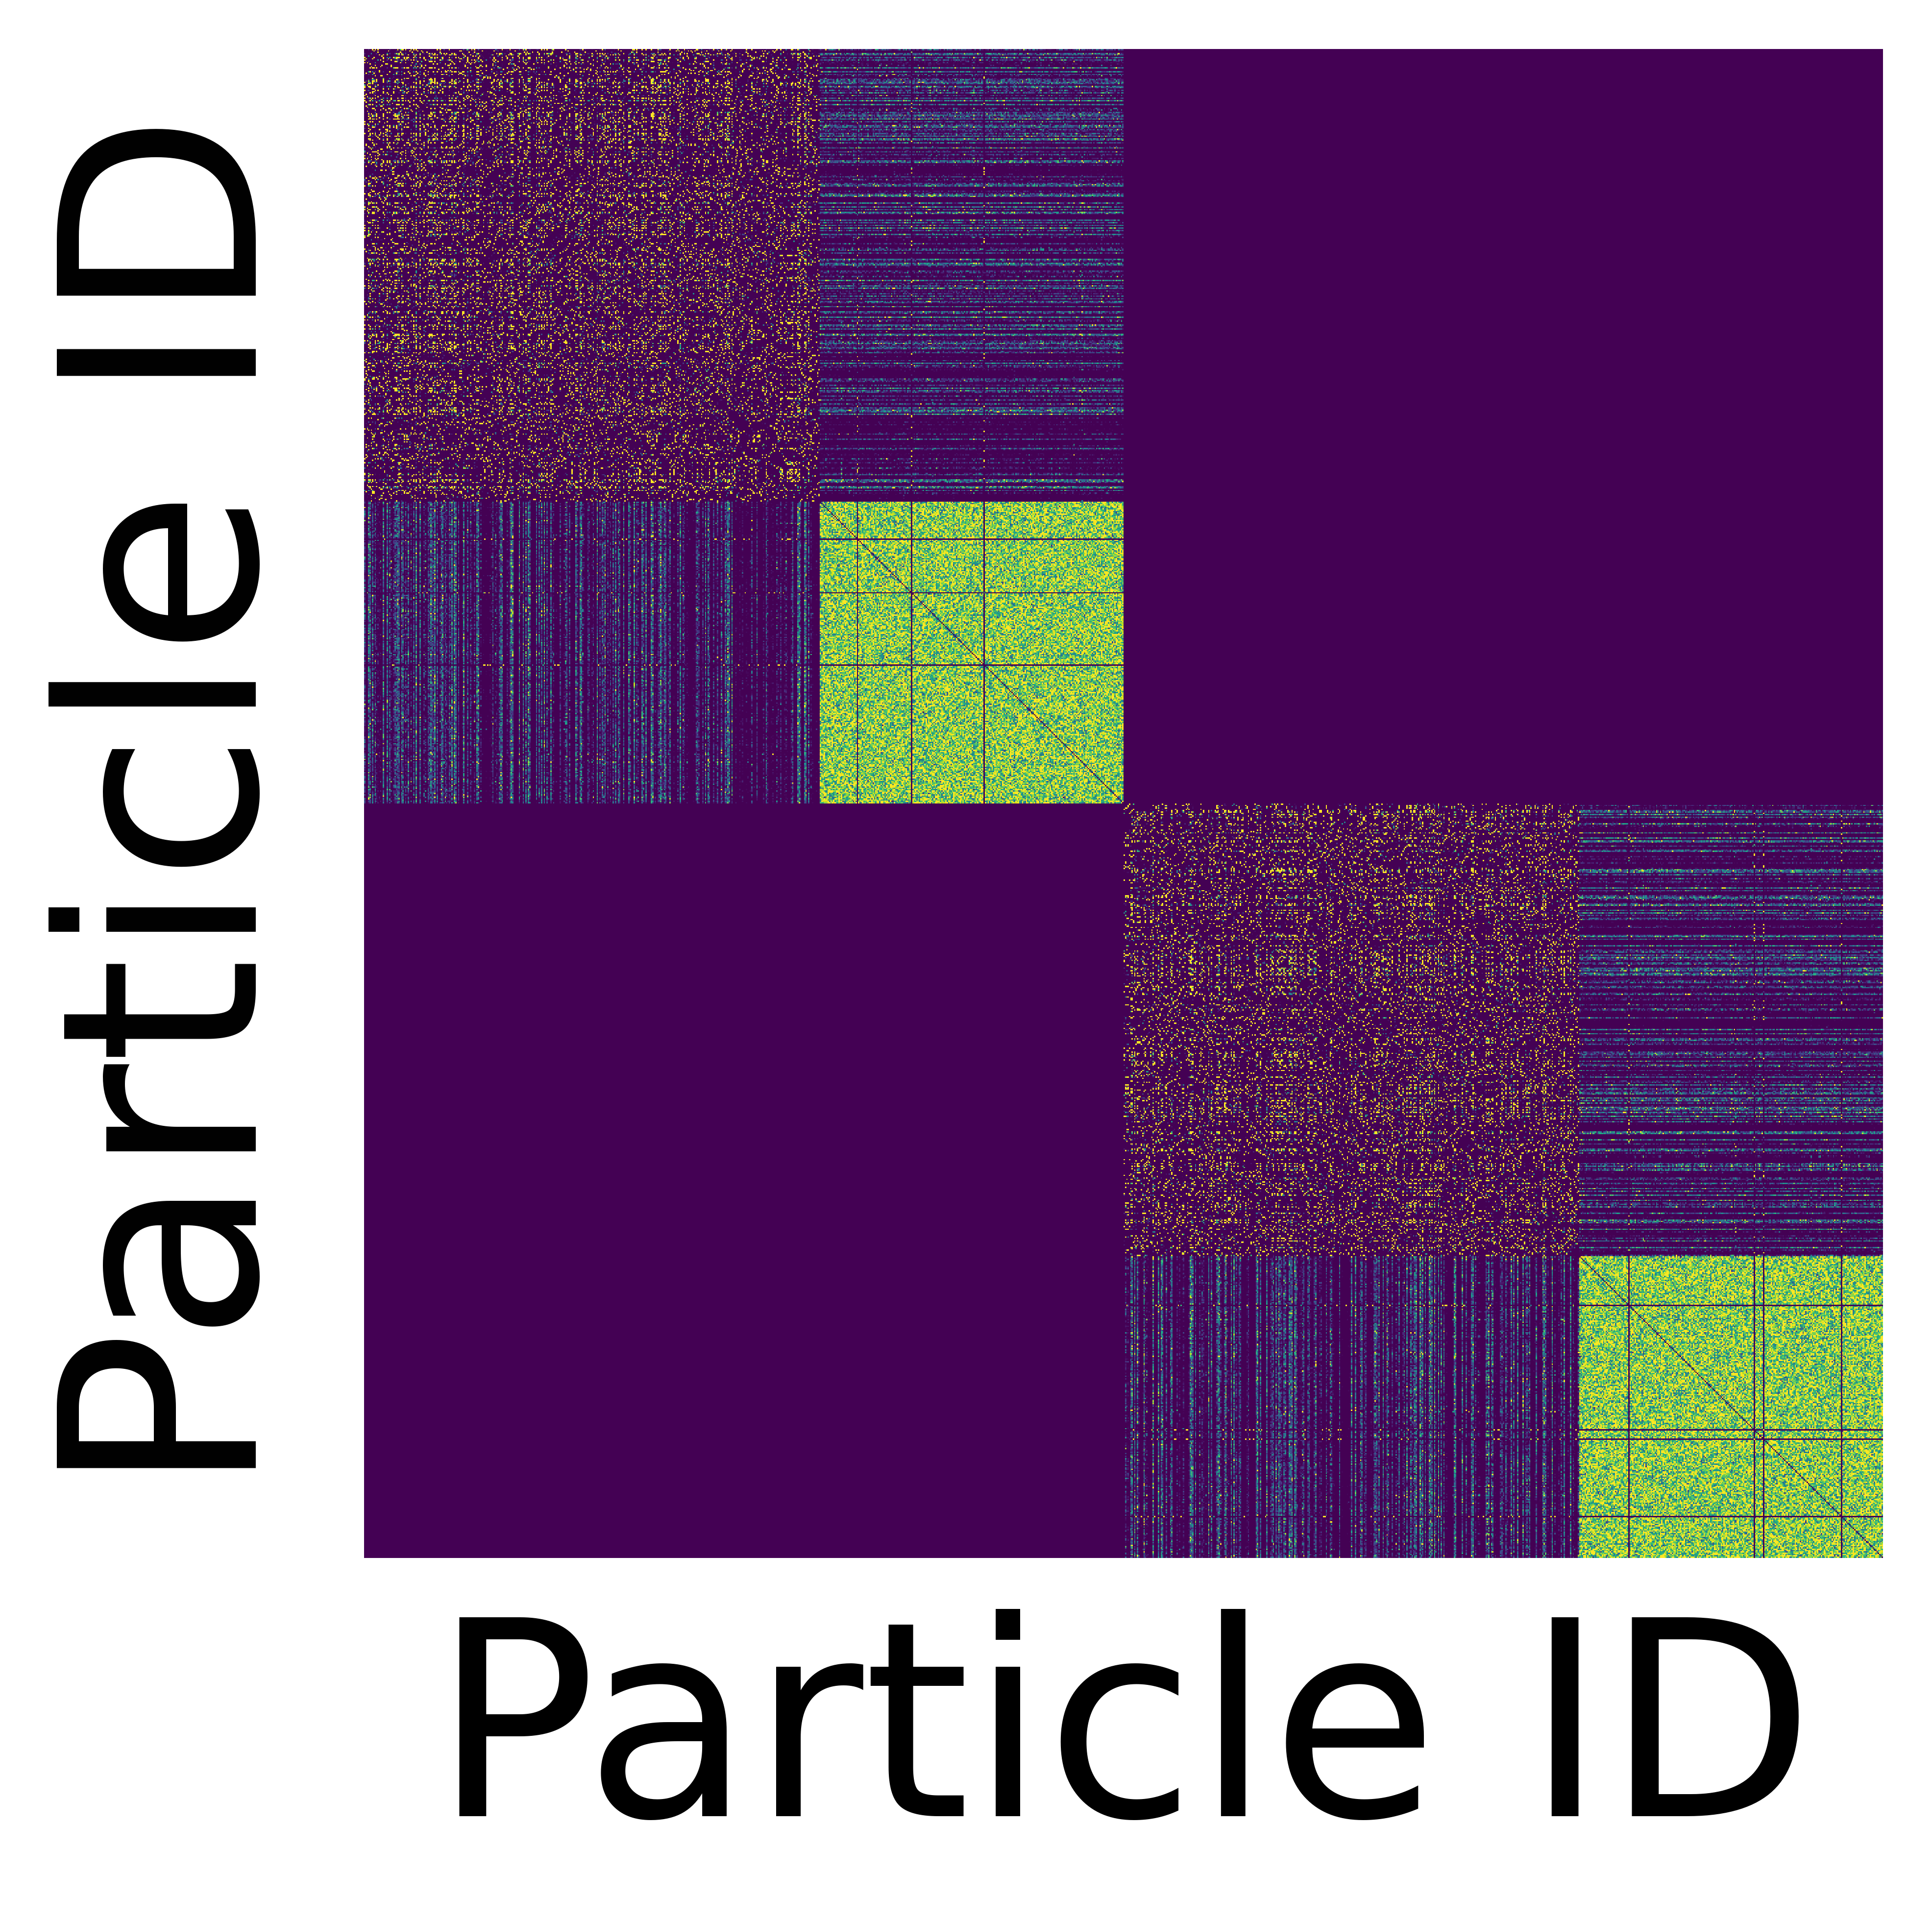

In [11]:
f, ax = plt.subplots(figsize=(4, 4), dpi=1000)
sns.heatmap(M, cmap='viridis',cbar=False, vmin=0, vmax=50, xticklabels=False, yticklabels=False, ax=ax)#,  row_cluster=True)
ax.set_xlabel('Particle ID', size=40)
ax.set_ylabel('Particle ID', size=40)
plt.savefig(OUT_DIR+"mat.png")

In [12]:
# Normalize M
M_n=list()
for i in range(len(M)):
    M_n.append((M[i]-np.mean(M[i]))/np.std(M[i]))
np.shape(M_n)

(1150, 1150)

In [13]:
colors = ['#2bff01','#0195ff','#ff6b01','#d501ff']
sns.color_palette(colors)

[(0.16862745098039217, 1.0, 0.00392156862745098),
 (0.00392156862745098, 0.5843137254901961, 1.0),
 (1.0, 0.4196078431372549, 0.00392156862745098),
 (0.8352941176470589, 0.00392156862745098, 1.0)]

0.0 666.2650216255064


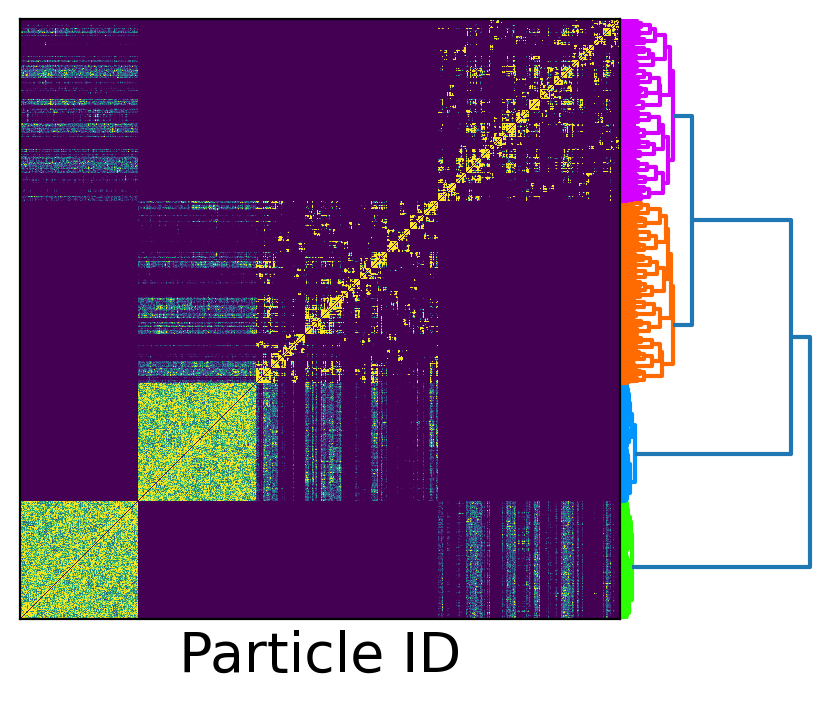

In [14]:
# HC on M_n
max_d = 4 # nclusters
metric = 'euclidean'
method = 'ward'

cM = pdist(M_n, metric)
fig = plt.figure(figsize=(5,5), dpi=200)
axdendro = fig.add_axes([0.6,0.1,0.2,0.6])
Y = linkage(cM, method=method)
hierarchy.set_link_color_palette(colors)
Z = dendrogram(Y, no_labels=True, color_threshold=250, orientation='right')
axdendro.set_xticks([])
axdendro.set_yticks([])
axdendro.axis('off')

axmatrix = fig.add_axes([0.0,0.0,0.6,0.8])
index = Z['leaves']
M_ren = M[index,:]
M_ren = M_ren[:,index]
im = axmatrix.matshow(M_ren, vmin=0, vmax=50, aspect='equal', origin='lower')
plt.gca().xaxis.tick_bottom()

axmatrix.set_xticks([int(N/2)])
axmatrix.set_yticks([])
axmatrix.set_xticklabels(["Particle ID"], fontsize=20)

axmatrix.tick_params(axis=u'both', which=u'both',length=0)
clusters_ = fcluster(Y, max_d, criterion='maxclust')
print(np.min(Z['dcoord']), np.max(Z['dcoord']))
plt.savefig(OUT_DIR+"mat_cl.svg")

## Write clusters (VMD readable)

In [15]:
cl = [ [i, clusters_[i]] for i in range(len(clusters_))]
cl_sort = sorted(cl, key=lambda x: x[0])
write_stat_clusters(cl_sort, OUT_DIR+'cl_stat.dat', INIT, END, STRIDE)

## Variability

In [16]:
# Compute variability V
cl_dyn, groups_dyn = dynamicity(clusters_, M)

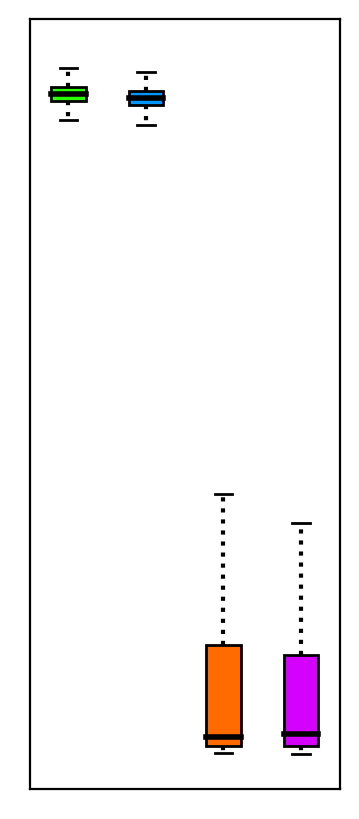

In [17]:
data = [groups_dyn[i] for i in range(len(groups_dyn))]
fig, ax = plt.subplots(figsize=(2,5), dpi=200)

bp = ax.boxplot(data,  patch_artist = True, showfliers=False)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
for median in bp['medians']:
    median.set(color ='black',
               linewidth = 2.)
    
for whisker in bp['whiskers']:
    whisker.set(color ='black',
                linewidth = 1.5,
                linestyle =":")

ylim = ax.get_ylim()
plt.ylim([ylim[0]-0.0001,ylim[1]+0.001])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.savefig(OUT_DIR+'v_bp.svg')

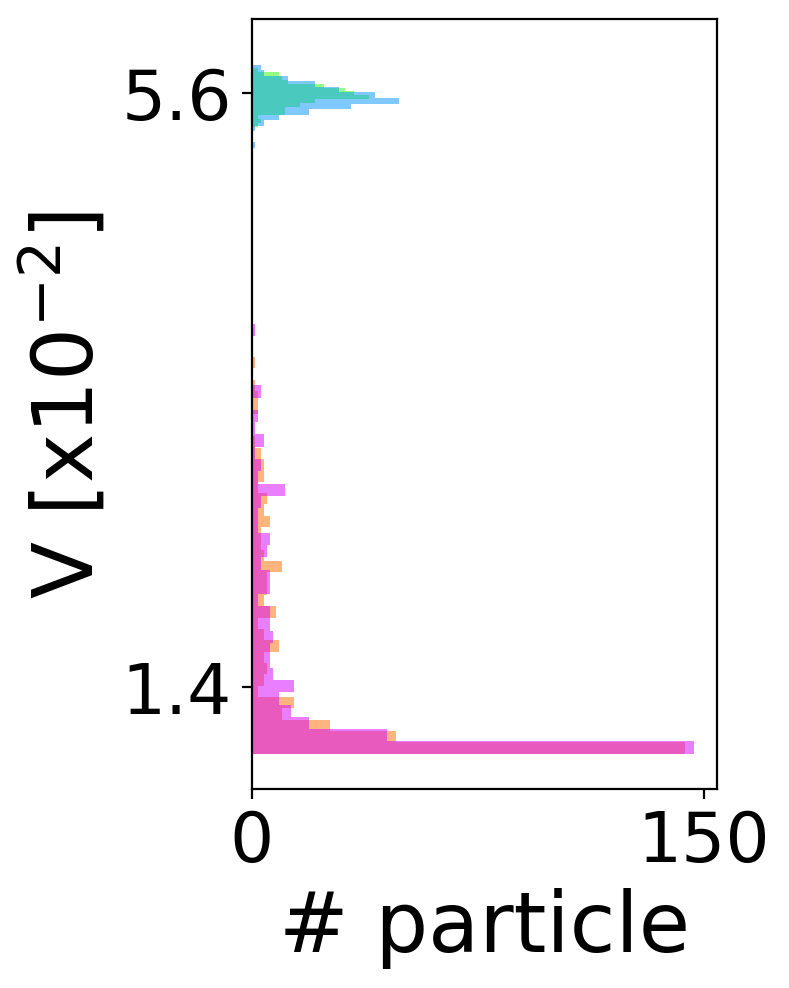

In [18]:
fig, ax = plt.subplots(figsize=(3,5), dpi=200)

plt.hist(groups_dyn[0], bins=15, alpha=0.5, color=colors[0], orientation='horizontal')
plt.hist(groups_dyn[1], bins=15, alpha=0.5, color=colors[1], orientation='horizontal')
plt.hist(groups_dyn[2], bins=35, alpha=0.5, color=colors[2], orientation='horizontal')
plt.hist(groups_dyn[3], bins=35, alpha=0.5, color=colors[3], orientation='horizontal')

plt.ylim([ylim[0]-0.0001,ylim[1]+0.001])

plt.xlabel('# particle', size=30)
plt.ylabel('V [x$10^{-2}$]', size=30)

_=ax.set_yticks([(np.round(np.mean(groups_dyn[0]),3)+np.round(np.mean(groups_dyn[1]),3))/2,(np.round(np.mean(groups_dyn[2]),3)+np.round(np.mean(groups_dyn[3]),3))/2])
_=ax.set_yticklabels([5.6,1.4], size=25)
_=ax.set_xticks([0,150])
_=ax.set_xticklabels([0,150], size=25)

plt.savefig(OUT_DIR+'dyn_d.svg')

# LOCAL ANALYSIS

## Contact analysis

In [19]:
# Compute C_i(t)
list_sum = perform_search_time(XYZ_UNI, rcut, INIT, END, STRIDE, False)

## Clustering

In [20]:
# Compute delta signlas
ncont_tot, _, _ , _ = local_dynamics(list_sum)

/home/martina/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [21]:
colors = ['cyan','limegreen','orange','purple']
sns.color_palette(colors)

[(0.0, 1.0, 1.0),
 (0.19607843137254902, 0.803921568627451, 0.19607843137254902),
 (1.0, 0.6470588235294118, 0.0),
 (0.5019607843137255, 0.0, 0.5019607843137255)]

In [22]:
# Savgol filter
window=100
polyorder = 2
ncont_rolling = savgol_filter(ncont_tot,polyorder,window,plot=False, ylim=[0,1], xticks=[0,500,1000], xticks_l=[0,5,10],yticks=[0,0.5,1], yticks_l=[0,0.5,1])

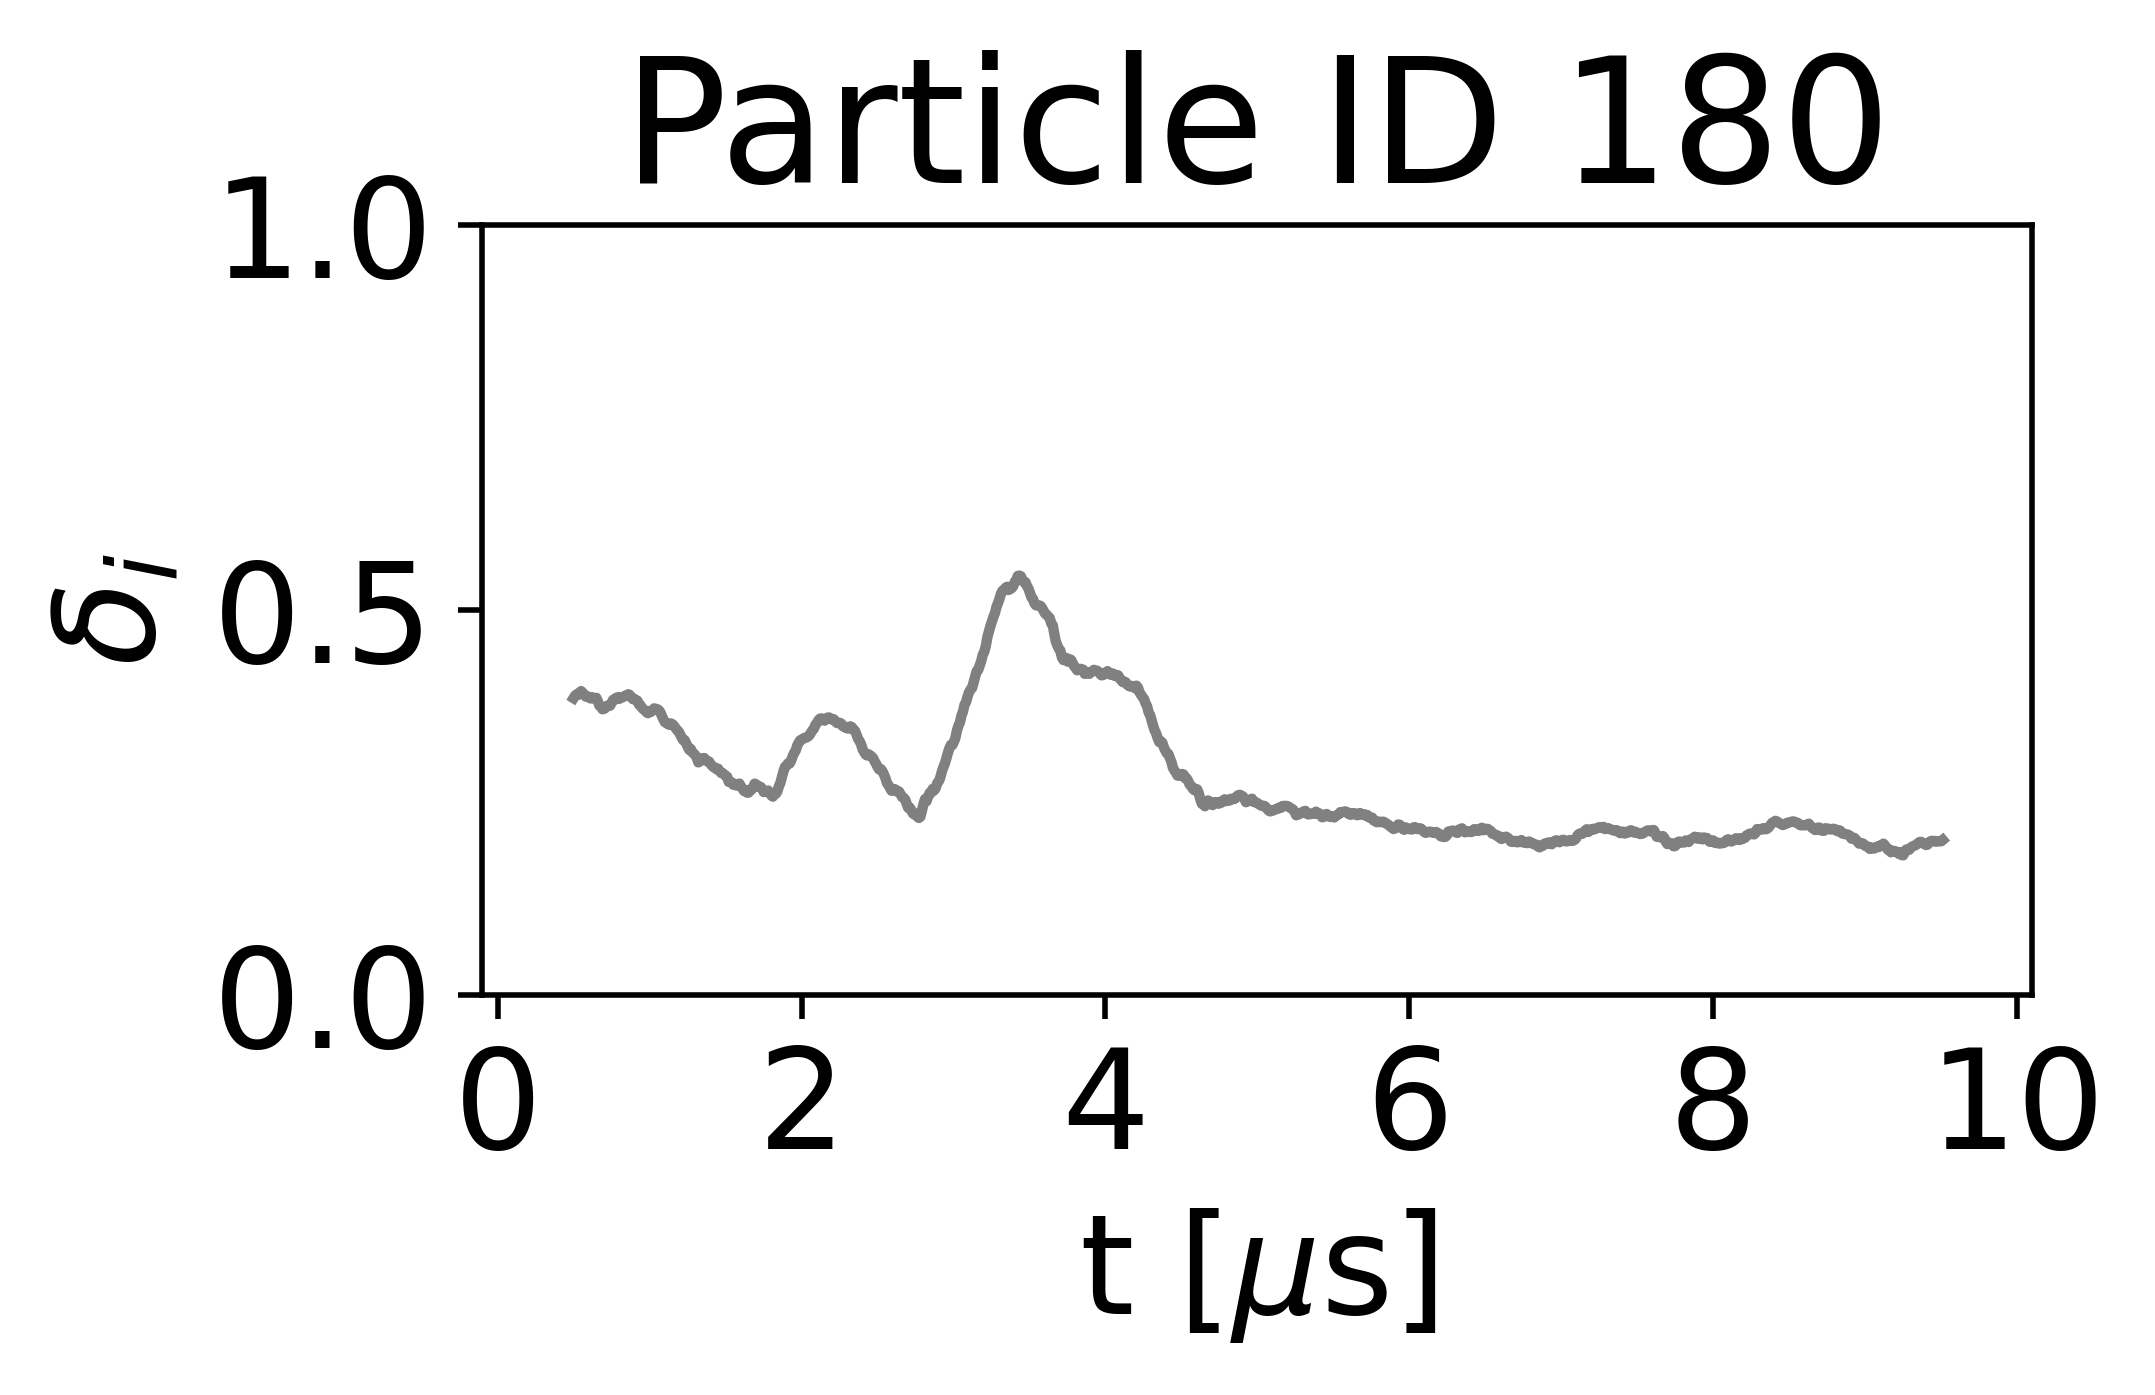

In [23]:
# delta exaples for i=180
fig, ax = plt.subplots(1, figsize=(4,2), dpi=500)
plt.title(r'Particle ID '+str(180), size=25)
plt.ylabel(r'$\delta_i$', size=20)
plt.xlabel(r't [$\mu$s]', size=20)
plt.xticks([0,200,400,600,800,1000])
ax.set_xticklabels([0,2,4,6,8,10], fontsize=20)

plt.yticks([0,0.5,1],size=20)
x = np.linspace(window/2,len(ncont_rolling[180])+window/2,len(ncont_rolling[180]))
plt.plot(x,ncont_rolling[180], color='gray')

plt.xlim([-10,1010])
plt.ylim([0,1])
plt.savefig(OUT_DIR+"signals_180.svg")
plt.show()

In [24]:
fl_ncont_rolling=flatten(ncont_rolling)

In [25]:
# KMean clustering
nclusters = 4
clusters = KMeans(nclusters).fit_predict(fl_ncont_rolling.reshape(-1, 1))
print("minmax: ",min(fl_ncont_rolling),max(fl_ncont_rolling))
data_KM = list()
for i in range(nclusters):
    data_KM.append(fl_ncont_rolling[clusters==i])

minmax:  0.12300497635181867 0.6701132895846765


In [26]:
cutoffs = [min(d_i) for d_i in data_KM]
cutoffs.remove(min(fl_ncont_rolling))
cutoffs = list(np.sort(cutoffs))
# Removing out of boundary cutoffs given by savgol interpolation 
cutoffs = list(filter(lambda num: num > 0, cutoffs))
cutoffs = list(filter(lambda num: num < 1, cutoffs))

In [27]:
#cutoffs=[0.2656237035520296, 0.4125867905423295, 0.5351619969485737]
cutoffs

[0.26466368689266534, 0.4105587956140898, 0.5333963058538086]

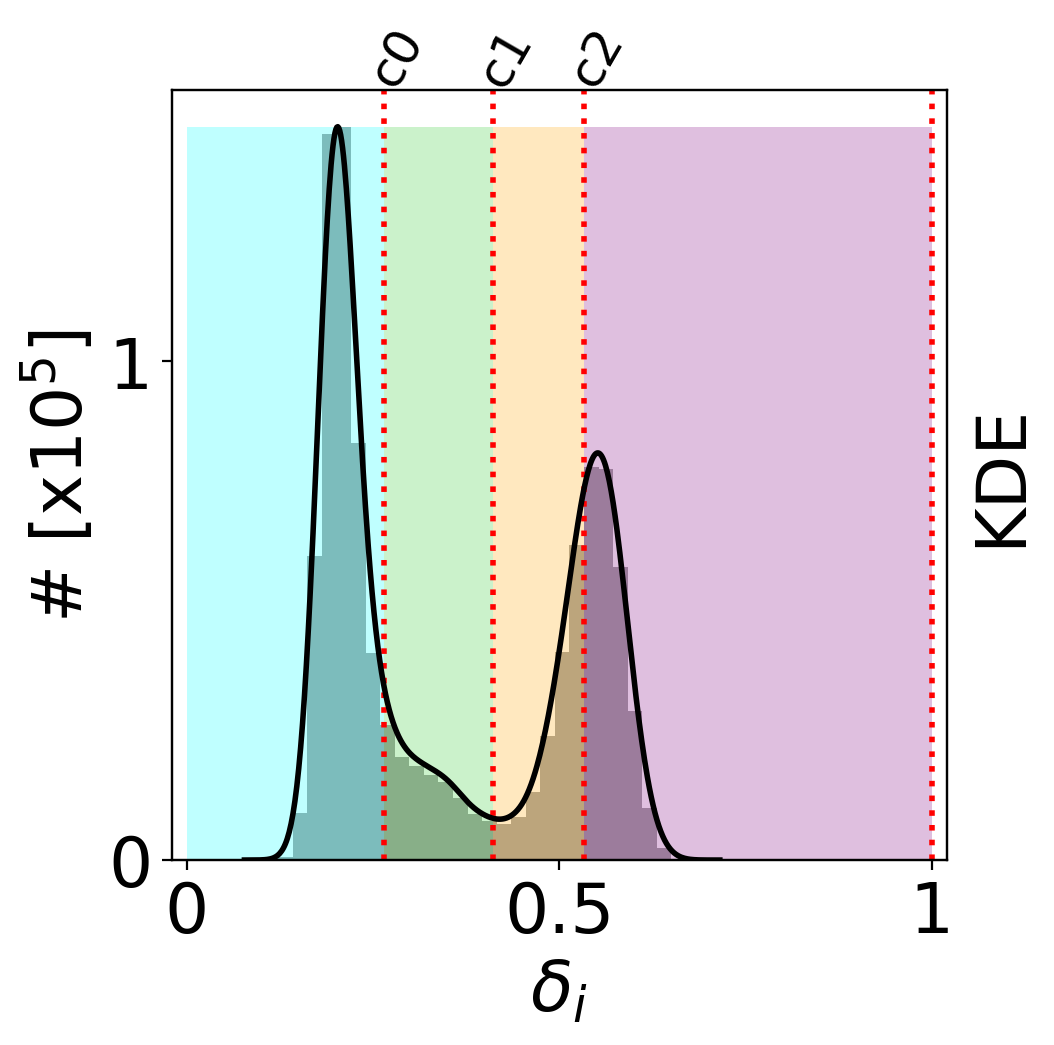

In [28]:
# Distribution of delta and KDE
fig, ax = plt.subplots(1, figsize=(5,5), dpi=200)
hist = ax.hist(fl_ncont_rolling, alpha=0.7, color='gray', bins='doane')

ax.set_xlim([-0.02,1.02])
ax.set_xlabel(r'$\delta_i$', size=25)
ax.set_xticks([0,0.5,1])
ax.set_xticklabels([0,0.5,1], size=25)

ax.set_ylabel("# [x$10^5$]", size=25)
ax.set_yticks([0,1e5,2e5])
ax.set_yticklabels([0,1,2])

ax.yaxis.get_offset_text().set_fontsize(18)
plt.yticks(fontsize=25)
ax2 = ax.twinx()
my_kde = sns.kdeplot(data=fl_ncont_rolling, bw_adjust=1.5, linewidth=2, color='black', gridsize=500, ax=ax2)

ax2.set_ylabel("KDE", size=25)
ax2.set_yticklabels([], size=25)
ax2.set_yticks([], [])

m_prev=0
for idx_m,m in enumerate(cutoffs):  
    center = (m-m_prev)/2.+m
    bin_size = (m-m_prev)/2.
    ax.bar(x=m, height=np.max(hist[0]), width=-(m-m_prev), align='edge', alpha=0.25, color=colors[idx_m], linewidth=2)     
    m_prev = m
    ax.axvline(x=m, c='red', linewidth=2, linestyle=':')
    plt.text(m-0.03,ax2.get_ylim()[1]+0.05,'c'+str(idx_m),rotation=60, fontsize=18)

ax.axvline(x=1, c='red', linewidth=2, linestyle=':')
ax.bar(x=1, height=np.max(hist[0]), width=-(1-m_prev), align='edge', alpha=0.25, color=colors[idx_m+1], linewidth=2)     
plt.savefig(OUT_DIR+'deltatau.svg')    

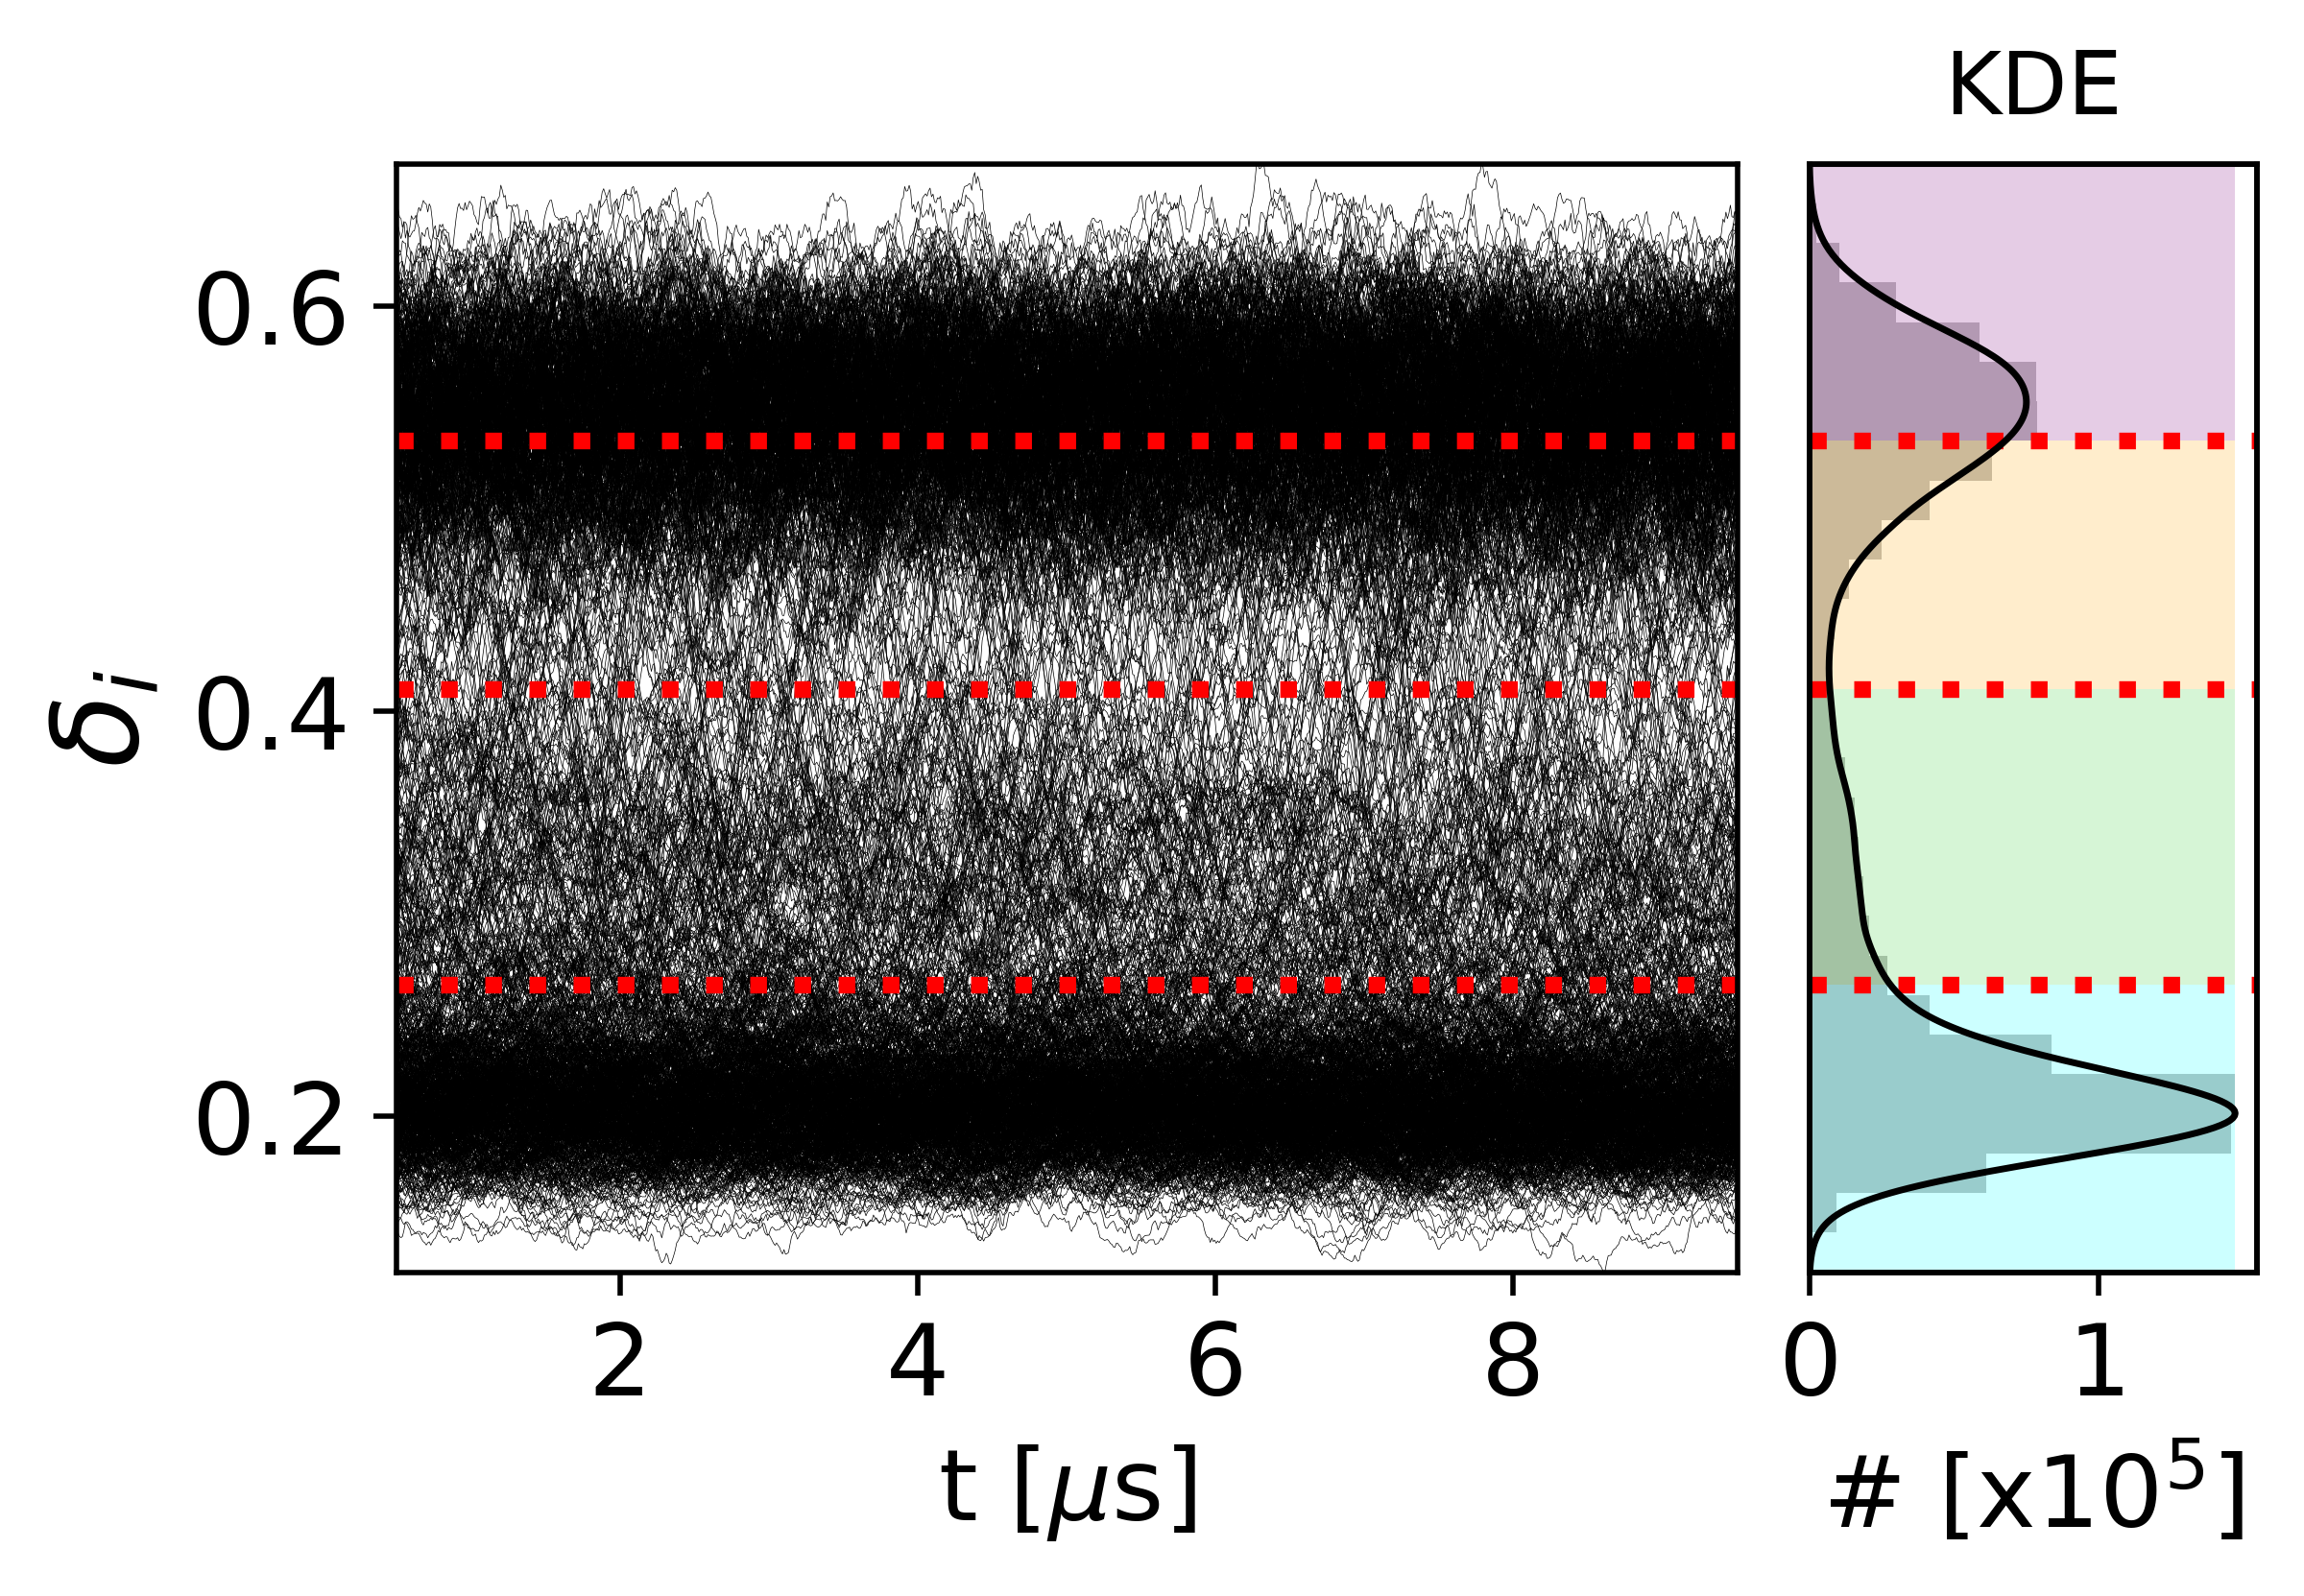

In [29]:
# Signals, distribution of delta, KDE 
fig, (ax, ax3) = plt.subplots(1, 2,figsize=(5,3), width_ratios=[3, 1], dpi=500)
ax.set_ylabel(r'$\delta_{i}$', size=18)
ax.set_yticks([0.2, 0.4, 0.6])
ax.set_yticklabels([0.2,0.4,0.6], fontsize=15)
ax.set_ylim((np.min(fl_ncont_rolling),np.max(fl_ncont_rolling)))

ax.set_xlabel(r't [$\mu$s]', size=15)
ax.set_xticks([0, 200,400,600,800])
ax.set_xticklabels([0, 2,4,6,8], fontsize=15)
ax.set_xlim((INIT/STRIDE+window/2, END/STRIDE-window/2))


x = np.linspace(window/2,len(ncont_rolling[0])+window/2,len(ncont_rolling[0]))
for p in range(0,N):
    ax.plot(x,ncont_rolling[p], color='black', linewidth=0.1)

for coff in range(len(cutoffs)):
    ax.hlines(cutoffs[coff], INIT/STRIDE+window/2, END/STRIDE-window/2, colors='r', linewidth=2.5, linestyle=':')

hist = ax3.hist(fl_ncont_rolling,color='silver', bins='doane', orientation=u'horizontal')

ax3.set_yticklabels([], size=15)
ax3.set_yticks([], [])
ax3.set_ylim((np.min(fl_ncont_rolling),np.max(fl_ncont_rolling)))

ax3.set_xlabel("# [x$10^5$]", size=15)
ax3.set_xticks([0,1e5,2e5])
ax3.set_xticklabels([0,1,2], size=15)


m_prev=0
for idx_m,m in enumerate(cutoffs):  
    center = (m-m_prev)/2.+m
    bin_size = (m-m_prev)/2.
    ax3.barh(y=m, height=-(m-m_prev), width=np.max(hist[0]), align='edge', alpha=0.2, color=colors[idx_m], linewidth=2)     
    m_prev = m

    ax3.axhline(y=m, c='red', linewidth=2.5, linestyle=':')

ax3.barh(y=ax.get_ylim()[1], height=-(ax.get_ylim()[1]-m_prev), width=np.max(hist[0]), align='edge', alpha=0.2, color=colors[idx_m+1], linewidth=2)     
ax2 = ax3.twiny()
my_kde = sns.kdeplot(y=fl_ncont_rolling, bw_adjust=0.8, linewidth=1, color='black', gridsize=500, ax=ax2)
ax2.set_xlabel("KDE", size=13)
ax2.set_xticklabels([], size=15)
ax2.set_xticks([], [])

plt.subplots_adjust(wspace=0.08)
plt.savefig(OUT_DIR+'signals_deltatau_all.png',bbox_inches='tight')    


In [30]:
# Finding clusters
chunk = [0]+cutoffs+[1+0.00001]
b_chunk = list()
for c in range(len(chunk)-1):
    b_chunk.append([chunk[c],chunk[c+1]])

In [31]:
cl_tot = list()
particle = [i for i in range(np.shape(ncont_rolling)[0])]
for p in particle:
    cl = list()
    for f_desc in ncont_rolling[p]:
        for idx_bc,bc in enumerate(b_chunk):
            if check(f_desc,bc):
                cl.append(idx_bc)
    cl_tot.append(cl)
cl_tot_rolling=flatten(cl_tot)

In [32]:
# Cluster percentages
unique, counts = np.unique(cl_tot_rolling, return_counts=True)
perc=counts/sum(counts)
perc

array([0.47919799, 0.11502292, 0.15601988, 0.2497592 ])

## Write clusters (VMD readable)

In [33]:
with open(OUT_DIR+'cl_dt.dat', 'w+') as file:
    for v in cl_tot_rolling:
        file.write(str(v)+'\n')

## Inter cluster exchange

In [34]:
# Exchanges probability matrix
cl_mat = np.transpose(cl_tot)
tmat=np.zeros((len(b_chunk),len(b_chunk)))
for f in range(len(cl_mat)-1):
    for e in range(N):
        tmat[cl_mat[f][e],cl_mat[f+1][e]]+=1
norm_row = np.sum(tmat, axis=1)

In [35]:
tmat_n = [list(tmat[i]/norm_row[i]) for i in range(len(b_chunk))]

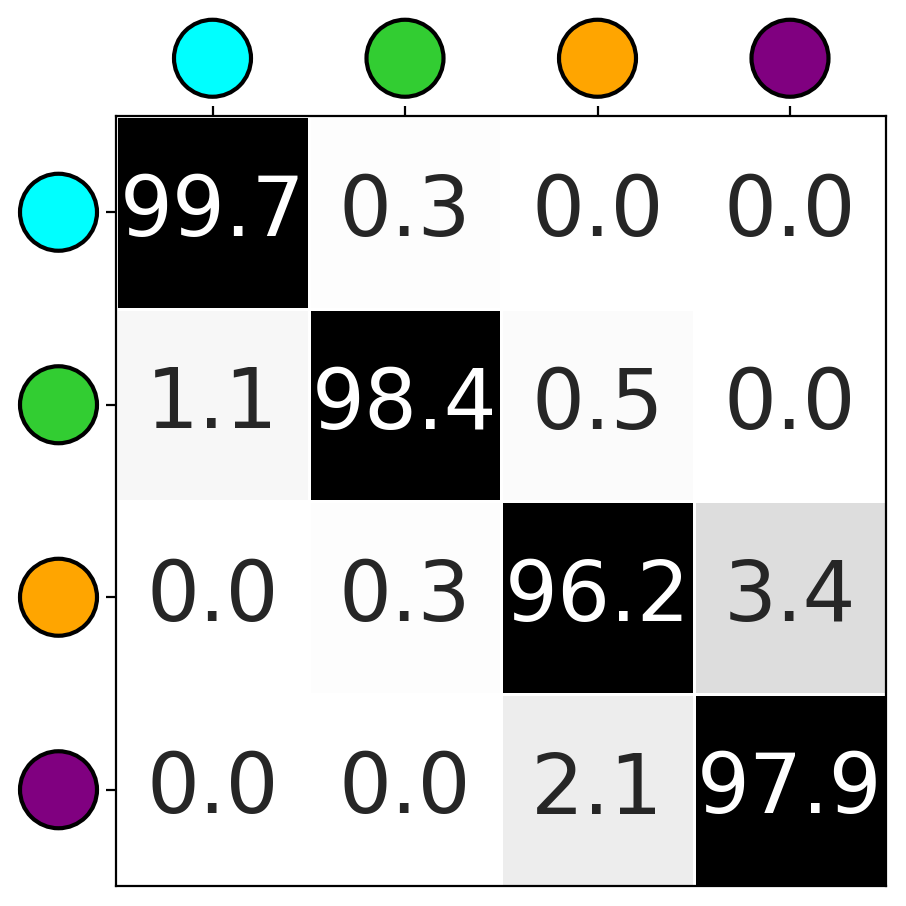

In [36]:
fig, ax = plt.subplots(1, figsize=(5,5),dpi=200)
PLTmatrixrates_label_colors_perc(np.array(tmat_n), colors, vmax=15, axes=ax, fontsize=30)
plt.savefig(OUT_DIR+'mat.svg')

[1.282845640017713, 1.3232776608433292, 1.3442380249211168]

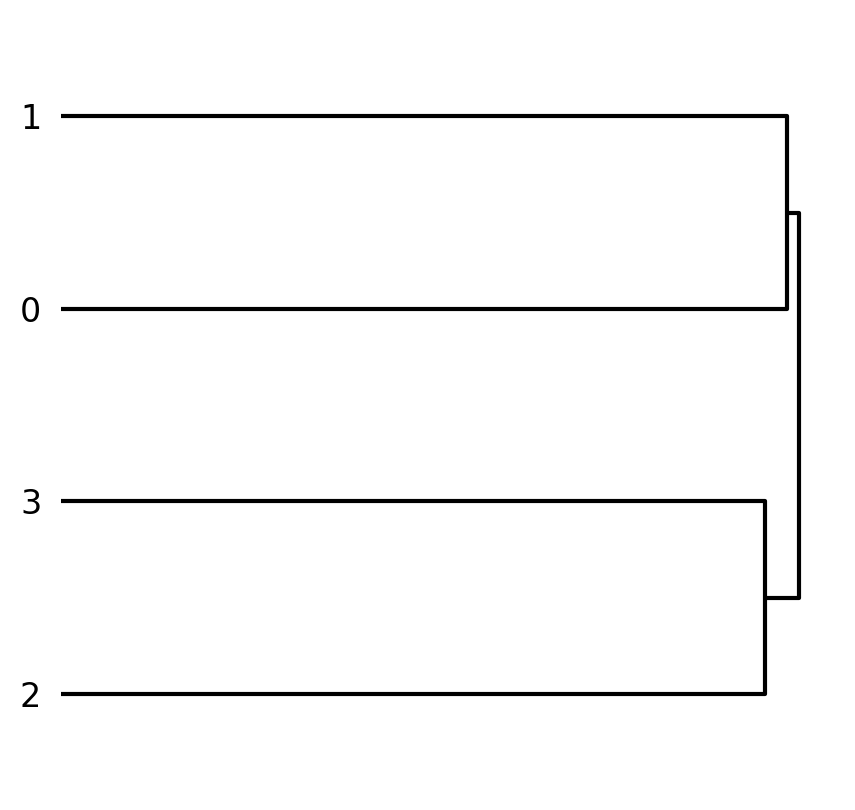

In [37]:
# HC on probability matrix
cM2 = pdist(tmat_n, 'correlation')
Z2 = linkage(cM2, method='single')
fig, ax = plt.subplots(1,figsize=(5, 5), dpi=200)
dn2 = dendrogram(Z2, orientation='right',distance_sort='ascending', above_threshold_color='black', ax=ax)
_ = ax.set_xticklabels("")
_ = ax.set_xticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig(OUT_DIR+'dendro.svg')
[v[1] for v in dn2['dcoord']]

## Macro clusters

In [38]:
colors = [ '#8a8acfff', '#ff9d9dff']

In [39]:
# Defining macro threshold based on HC
cutoffs = [0.4125867905423295]

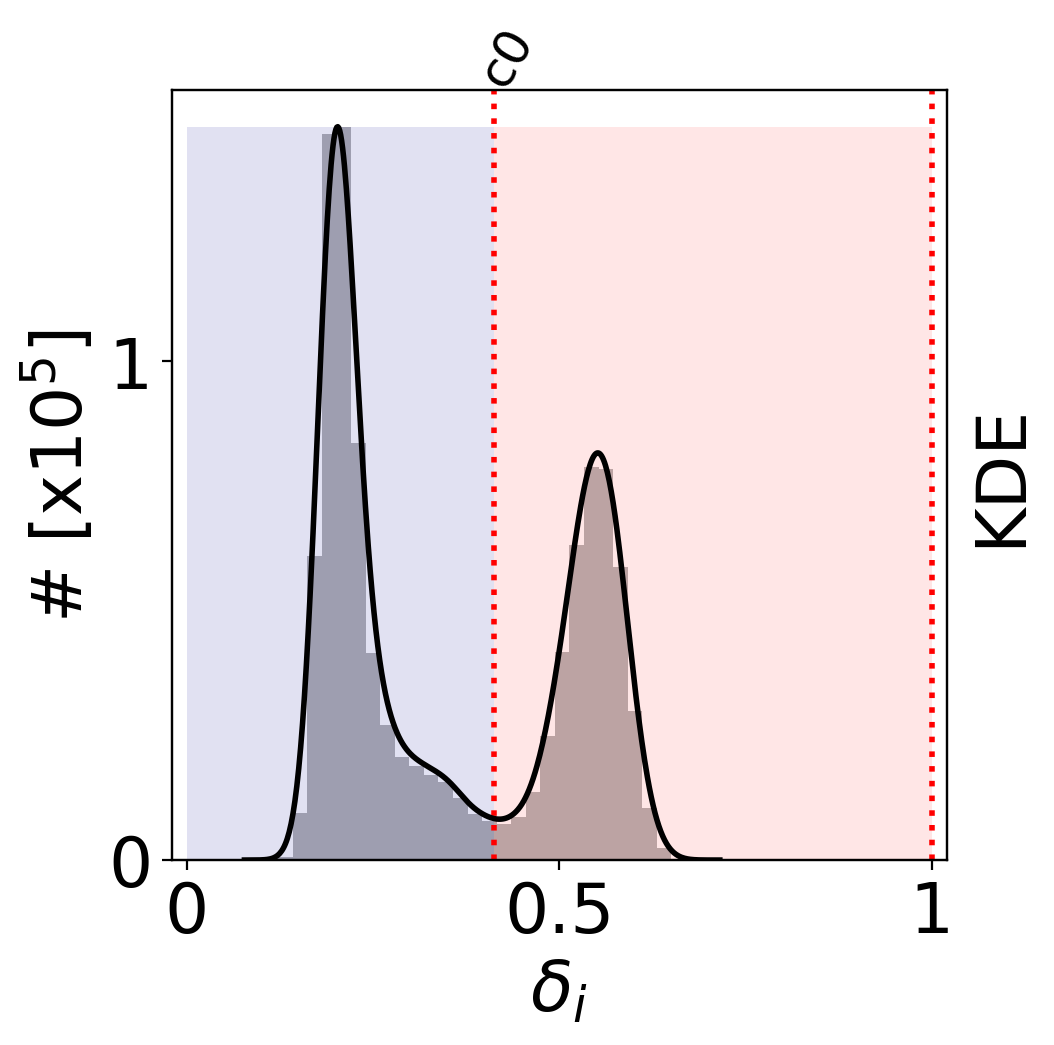

In [48]:
fig, ax = plt.subplots(1, figsize=(5,5), dpi=200)
hist = ax.hist(fl_ncont_rolling, alpha=0.7, color='gray', bins='doane')

ax.set_xlim([-0.02,1.02])
ax.set_xlabel(r'$\delta_i$', size=25)
ax.set_xticks([0,0.5,1])
ax.set_xticklabels([0,0.5,1], size=25)

ax.set_ylabel("# [x$10^5$]", size=25)
ax.set_yticks([0,1e5,2e5])
ax.set_yticklabels([0,1,2])

ax.yaxis.get_offset_text().set_fontsize(18)
plt.yticks(fontsize=25)
ax2 = ax.twinx()
my_kde = sns.kdeplot(data=fl_ncont_rolling, bw_adjust=1.5, linewidth=2, color='black', gridsize=500, ax=ax2)

ax2.set_ylabel("KDE", size=25)
ax2.set_yticklabels([], size=25)
ax2.set_yticks([], [])

m_prev=0
for idx_m,m in enumerate(cutoffs):  
    center = (m-m_prev)/2.+m
    bin_size = (m-m_prev)/2.
    ax.bar(x=m, height=np.max(hist[0]), width=-(m-m_prev), align='edge', alpha=0.25, color=colors[idx_m], linewidth=2)     
    m_prev = m
    ax.axvline(x=m, c='red', linewidth=2, linestyle=':')
    plt.text(m-0.03,ax2.get_ylim()[1]+0.05,'c'+str(idx_m),rotation=60, fontsize=18)

ax.axvline(x=1, c='red', linewidth=2, linestyle=':')
ax.bar(x=1, height=np.max(hist[0]), width=-(1-m_prev), align='edge', alpha=0.25, color=colors[idx_m+1], linewidth=2)     
plt.savefig(OUT_DIR+'deltatau_macro.svg')    

In [41]:
chunk = [0]+cutoffs+[1+0.00001]
b_chunk = list()
for c in range(len(chunk)-1):
    b_chunk.append([chunk[c],chunk[c+1]])

In [42]:
cl_tot = list()
particle = [i for i in range(np.shape(ncont_rolling)[0])]
for p in particle:
    cl = list()
    for f_desc in ncont_rolling[p]:
        for idx_bc,bc in enumerate(b_chunk):
            if check(f_desc,bc):
                cl.append(idx_bc)
    cl_tot.append(cl)
cl_tot_rolling=flatten(cl_tot)

In [43]:
unique, counts = np.unique(cl_tot_rolling, return_counts=True)
perc=counts/sum(counts)
perc

array([0.59493992, 0.40506008])

In [44]:
cl_mat = np.transpose(cl_tot)
tmat=np.zeros((len(b_chunk),len(b_chunk)))
for f in range(len(cl_mat)-1):
    for e in range(N):
        tmat[cl_mat[f][e],cl_mat[f+1][e]]+=1
norm_row = np.sum(tmat, axis=1)

In [45]:
tmat_n = [list(tmat[i]/norm_row[i]) for i in range(len(b_chunk))]

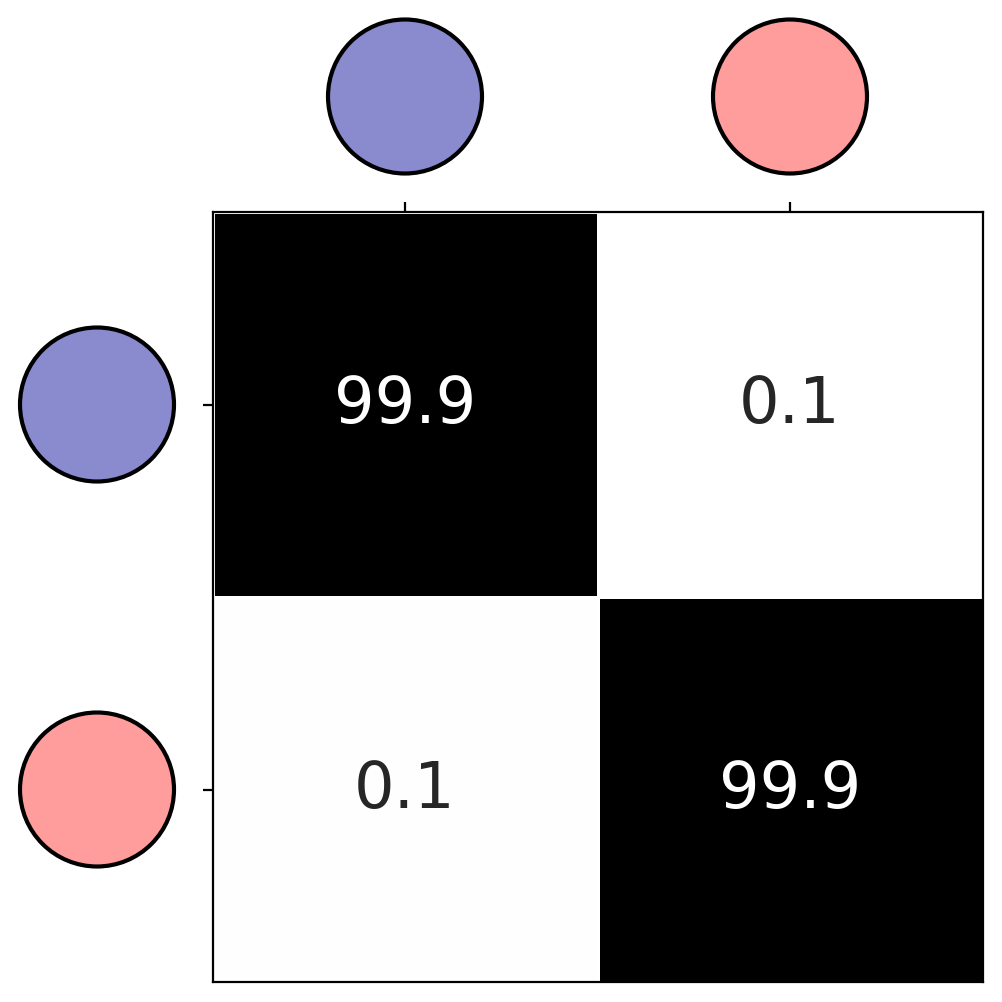

In [46]:
fig, ax = plt.subplots(1, figsize=(5,5),dpi=200)
PLTmatrixrates_label_colors_perc(np.array(tmat_n), colors, vmax=15, axes=ax)
plt.savefig(OUT_DIR+'mat_macro.svg')